In [1]:
%load_ext lab_black

In [2]:
import argparse
import json
import math
import os
import shutil
import sys
import random
from collections import defaultdict
from importlib import import_module
from itertools import product
from multiprocessing import cpu_count
from pathlib import Path
from pprint import pformat

import cv2
import imageio
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
import matplotlib.pyplot as plt
from easydict import EasyDict
from PIL import Image
from torch import nn, optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2

from effdet_torch_singlefile import EfficientDet

In [3]:
def seed_everything(seed, deterministic=False):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = not deterministic

In [4]:
def denormalize(
    x: torch.Tensor,
    mean=torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32),
    std=torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32),
):
    if x.dim() == 4:
        mean = mean.view(1, 3, 1, 1).to(x.device)
        std = std.view(1, 3, 1, 1).to(x.device)
    elif x.dim() == 3:
        mean = mean.view(3, 1, 1).to(x.device)
        std = std.view(3, 1, 1).to(x.device)

    return x * std + mean

In [5]:
def normalize(
    x: torch.Tensor,
    mean=torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32),
    std=torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32),
):
    if x.dim() == 4:
        mean = mean.view(1, 3, 1, 1).to(x.device)
        std = std.view(1, 3, 1, 1).to(x.device)
    elif x.dim() == 3:
        mean = mean.view(3, 1, 1).to(x.device)
        std = std.view(3, 1, 1).to(x.device)

    return (x - mean) / std

In [6]:
def imshows(*ims, figsize=None):
    figsize = figsize or (len(ims) * 6, 4)
    plt.figure(figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(1, len(ims), i + 1)
        plt.imshow(im)
    plt.tight_layout()
    plt.show()

In [7]:
__effdet_test_without_train_config__ = """
seed: 20210309

det_model: 
  name: efficientdet-d7

dataset:
  dir: data/ori
  
  crop:
    - 192
    - 28
    - 1728
    - 1052

  input_width: 1536
  input_height: 1024
"""

In [8]:
C = EasyDict(yaml.load(__effdet_test_without_train_config__, yaml.FullLoader))
seed_everything(C.seed)

## 모델 로딩

In [9]:
model = EfficientDet(C.det_model.name, pretrained=True)
model.cuda()
model.eval()
torch.set_grad_enabled(False)

Load pretrained /home/s0/.cache/torch/hub/checkpoints/efficientdet-d7.pth


## 데이터셋 로딩

In [10]:
sizes = [(768, 512), (1536, 1024)]
rotations = [0, 1, 3]
vflips = [False, True]
hflips = [False, True]
gammas = [0.8, 1.0]

In [11]:
test_files = sorted(list(Path("data/ori/test_imgs/").glob("*.jpg")))
len(test_files)

1600

In [12]:
class TestDetDataset(Dataset):
    def __init__(self, config, files):
        super().__init__()
        self.C = config
        self.files = files
        dataset = self.C.dataset

        T = []
        T.append(A.Crop(*dataset.crop))
        T.append(A.Resize(dataset.input_height, dataset.input_width))
        T.append(A.Normalize())
        T.append(ToTensorV2())

        self.transform = A.Compose(transforms=T)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = str(self.files[idx])
        image = imageio.imread(file)
        a = self.transform(image=image)

        image = a["image"]

        return file, image

In [13]:
ds = TestDetDataset(C, test_files)
ds[0]

('data/ori/test_imgs/649-2-4-32-Z148_A-0000001.jpg',
 tensor([[[-1.3302, -1.3302, -1.3302,  ...,  1.8379,  1.8379,  1.8379],
          [-1.3302, -1.3302, -1.3302,  ...,  1.8379,  1.8379,  1.8379],
          [-1.3302, -1.3302, -1.3302,  ...,  1.8379,  1.8379,  1.8379],
          ...,
          [-1.2445, -1.2445, -1.2445,  ..., -1.0390, -1.0390, -1.0390],
          [-1.2445, -1.2445, -1.2445,  ..., -1.0390, -1.0390, -1.0390],
          [-1.2274, -1.2274, -1.2274,  ..., -1.0390, -1.0390, -1.0390]],
 
         [[-1.3354, -1.3354, -1.3354,  ...,  2.0784,  2.0784,  2.0784],
          [-1.3354, -1.3354, -1.3354,  ...,  2.0784,  2.0784,  2.0784],
          [-1.3354, -1.3354, -1.3354,  ...,  2.0784,  2.0784,  2.0784],
          ...,
          [-1.1078, -1.1078, -1.1078,  ..., -0.8978, -0.8978, -0.8978],
          [-1.1078, -1.1078, -1.1078,  ..., -0.8978, -0.8978, -0.8978],
          [-1.0903, -1.0903, -1.0903,  ..., -0.8978, -0.8978, -0.8978]],
 
         [[-1.1073, -1.1073, -1.1073,  ...,  2.

In [14]:
L = len(ds)

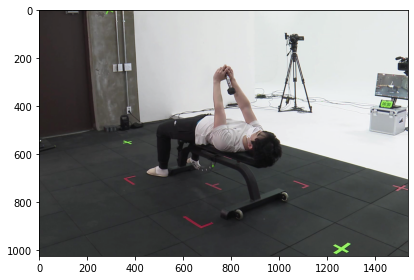

In [15]:
file, img = ds[0]
img_np = denormalize(img).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
imshows(img_np)

In [16]:
imgs = []
with tqdm(total=L, ncols=100, file=sys.stdout) as t:
    for i in range(L):
        file, img = ds[i]
        for size, rotation, vflip, hflip, gamma in product(sizes, rotations, vflips, hflips, gammas):
            img_ = img.cuda().unsqueeze(0)
            if gamma != 1.0:
                img_ = normalize(denormalize(img_) ** gamma)
            if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                img_ = F.interpolate(img_, size[::-1])
            if rotation > 0:
                img_ = torch.rot90(img_, k=rotation, dims=(2, 3))
            if vflip:
                img_ = torch.flip(img_, dims=(2,))
            if hflip:
                img_ = torch.flip(img_, dims=(3,))

            img_np = imgs.append(denormalize(img_).mul(255).squeeze(0).permute(1, 2, 0).cpu().type(torch.uint8).numpy())

        t.update()
        break

  0%|                                                              | 1/1600 [00:00<10:44,  2.48it/s]


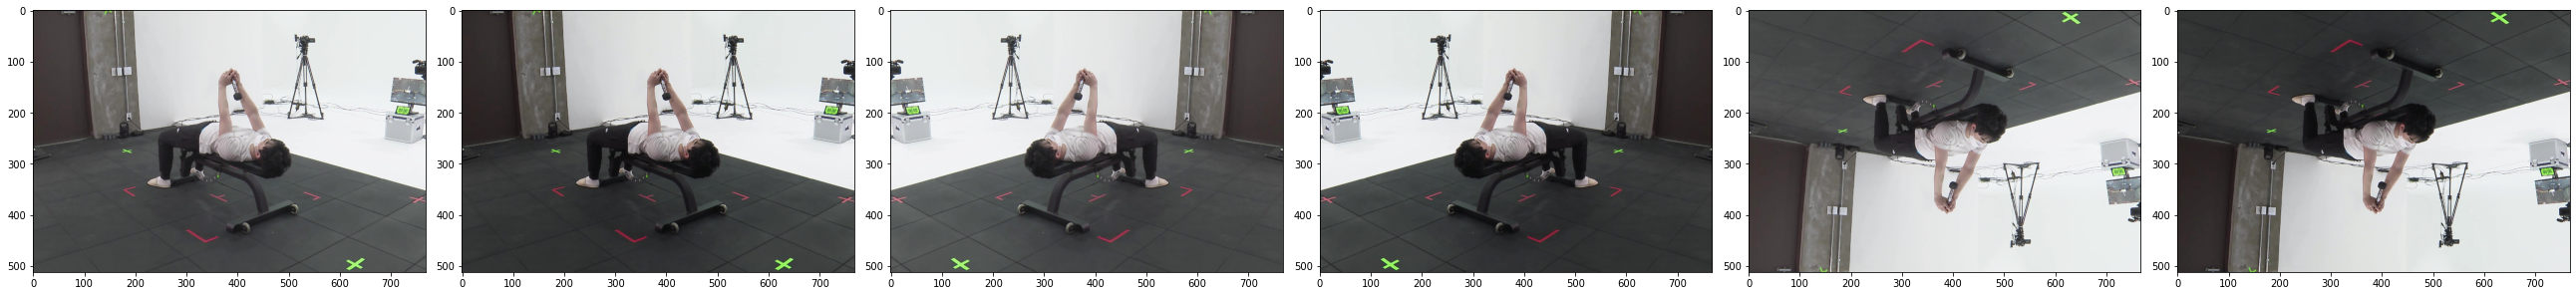

In [17]:
imshows(*imgs[0:6])

## TTA

In [18]:
outdir = Path("results/submit/effdet-pretrained")
outdir.mkdir(parents=True, exist_ok=True)

In [ ]:
info = []
with tqdm(total=L, ncols=100, file=sys.stdout) as t:
    for i in range(L):
        file, img = ds[i]
        file = Path(file)
        rois, scores = [], []
        for size, rotation, vflip, hflip, gamma in product(sizes, rotations, vflips, hflips, gammas):
            img_ = img.cuda().unsqueeze(0)
            if gamma != 1.0:
                img_ = normalize(denormalize(img_) ** gamma)
            if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                img_ = F.interpolate(img_, size[::-1])
            if rotation > 0:
                img_ = torch.rot90(img_, k=rotation, dims=(2, 3))
            if vflip:
                img_ = torch.flip(img_, dims=(2,))
            if hflip:
                img_ = torch.flip(img_, dims=(3,))

            pannot = model(img_)[0]

            roi, score = None, None
            for roi_, class_id_, score_ in zip(pannot["rois"], pannot["class_ids"], pannot["scores"]):
                if class_id_ != 0:
                    continue

                if score_ < 0.4:
                    continue

                # 가장 넓이가 큰 ROI를 선택
                if roi is None or (roi[2] - roi[0]) * (roi[3] - roi[1]) < (roi_[2] - roi_[0]) * (roi_[3] - roi_[1]):
                    roi = roi_
                    score = score_

            # 조건에 맞는 ROI가 없으면 무시
            if roi is not None and score is not None:
                roi, score = pannot["rois"][0], pannot["scores"][0]
                h, w = img_.shape[2:]

                if hflip:
                    a, b, c, d = roi.copy()
                    roi = np.array([w - c, b, w - a, d], dtype=np.float32)
                if vflip:
                    a, b, c, d = roi.copy()
                    roi = np.array([a, h - d, c, h - b], dtype=np.float32)
                if rotation > 0:
                    a, b, c, d = roi.copy()
                    if rotation == 1:
                        roi = np.array([h - d, a, h - b, c], dtype=np.float32)
                        h, w = w, h
                    elif rotation == 2:
                        roi = np.array([w - c, h - d, w - a, h - b], dtype=np.float32)
                    elif rotation == 3:
                        roi = np.array([b, w - c, d, w - a], dtype=np.float32)
                        h, w = w, h
                if C.dataset.input_height != size[1] and C.dataset.input_width != size[0]:
                    roi[0::2] = roi[0::2] * C.dataset.input_width / w
                    roi[1::2] = roi[1::2] * C.dataset.input_height / h

                rois.append(roi)
                scores.append(score)

        rois = np.stack(rois)
        roi = np.median(rois, 0)
        roi[0::2] += C.dataset.crop[0]
        roi[1::2] += C.dataset.crop[1]
        offset = C.dataset.crop[:2]

        info.append(roi.tolist())

        # 이미지 파일로 저장
        img_ori = imageio.imread(file)
        cv2.rectangle(img_ori, (int(roi[0]), int(roi[1])), (int(roi[2]), int(roi[3])), (255, 0, 0), 3)
        imageio.imwrite(outdir / f"{i:04d}-{file.name}", img_ori)

        t.update()

대략 2시간 정도 걸립니다...

In [ ]:
with open('results/submit/effdet-pretrained/info.json', 'w') as f:
    json.dump(info, f)